In [3]:
import numpy as np
import pandas as pd

df = pd.read_excel('1688640705_hr_comma_sep.xlsx')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [9]:
missing = df.isna().sum().sort_values(ascending=False)
missing # no value missing - all present

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
left,0
promotion_last_5years,0
sales,0
salary,0


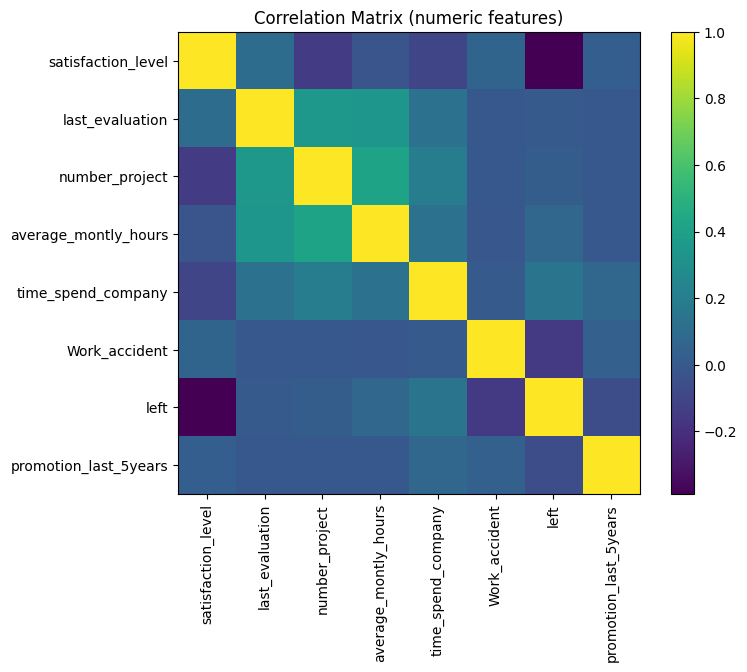

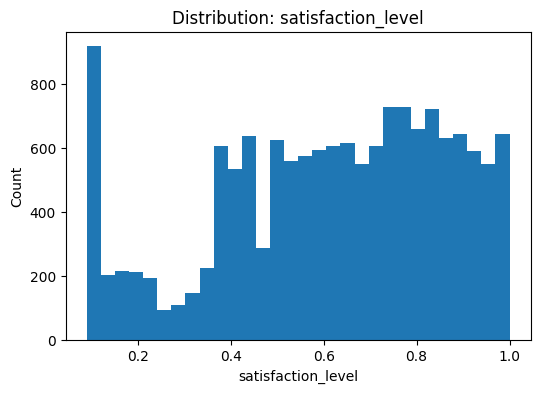

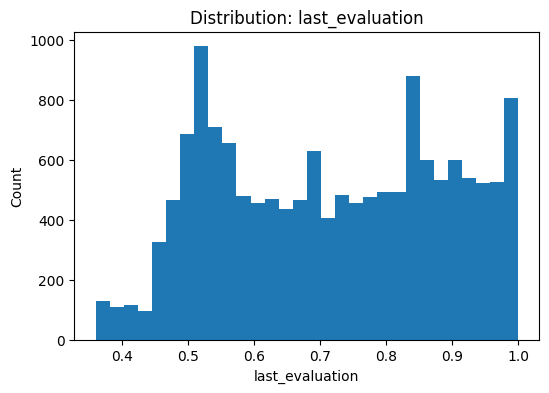

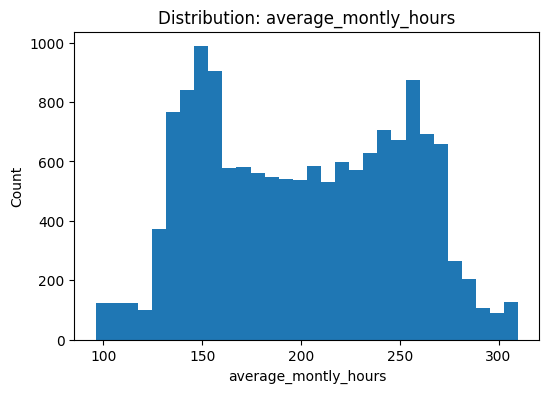

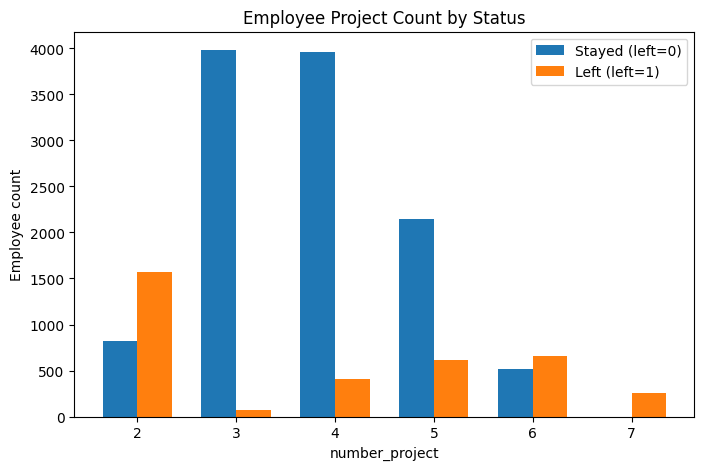

In [16]:
#EDA

import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(8, 6))
    plt.imshow(corr, interpolation="nearest")
    plt.title("Correlation Matrix (numeric features)")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar()

for c in ["satisfaction_level", "last_evaluation", "average_montly_hours"]:
    if c in df.columns:
        plt.figure(figsize=(6, 4))
        plt.hist(df[c].dropna(), bins=30)
        plt.title(f"Distribution: {c}")
        plt.xlabel(c); plt.ylabel("Count")

if "number_project" in df.columns:
    proj_counts = df.groupby(["number_project", "left"]).size().reset_index(name="count")
    pv = proj_counts.pivot(index="number_project", columns="left", values="count").fillna(0).sort_index()

    plt.figure(figsize=(8, 5))
    idx = np.arange(len(pv.index)); width = 0.35
    left0 = pv[0].values if 0 in pv.columns else np.zeros(len(idx))
    left1 = pv[1].values if 1 in pv.columns else np.zeros(len(idx))
    plt.bar(idx - width/2, left0, width, label="Stayed (left=0)")
    plt.bar(idx + width/2, left1, width, label="Left (left=1)")
    plt.xticks(idx, pv.index)
    plt.xlabel("number_project"); plt.ylabel("Employee count")
    plt.title("Employee Project Count by Status")
    plt.legend()

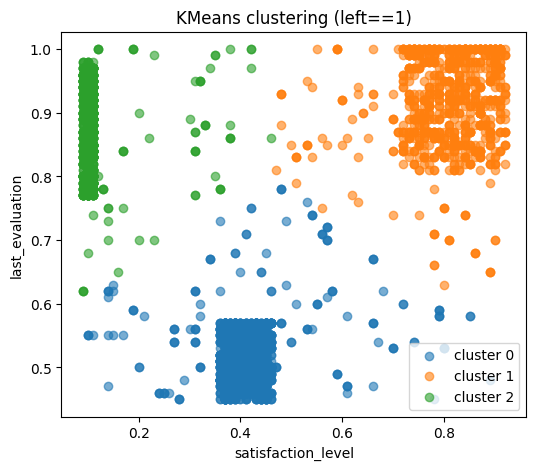

In [17]:
#CLUSTERING
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

clust_cols = ["satisfaction_level", "last_evaluation"]
if all(c in df.columns for c in clust_cols):
    left_df = df[df["left"] == 1].copy()
    if len(left_df) > 0:
        Xc = left_df[clust_cols].astype(float).values
        scaler = StandardScaler()
        Xc_scaled = scaler.fit_transform(Xc)
        km3 = KMeans(n_clusters=3, n_init=20, random_state=42)
        left_df["cluster"] = km3.fit_predict(Xc_scaled)
        centroids = scaler.inverse_transform(km3.cluster_centers_)
        plt.figure(figsize=(6, 5))
        for k in range(3):
            pts = left_df[left_df["cluster"] == k]
            plt.scatter(pts["satisfaction_level"], pts["last_evaluation"], alpha=0.6, label=f"cluster {k}")
        plt.xlabel("satisfaction_level"); plt.ylabel("last_evaluation")
        plt.title("KMeans clustering (left==1)")
        plt.legend()

In [33]:
#SMOTE + CV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = obj_cols
num_cols_full = [c for c in df.columns if c not in cat_cols + ["left"]]

X_cat = pd.get_dummies(df[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=df.index)
X_num = df[num_cols_full].copy()
X_all = pd.concat([X_num, X_cat], axis=1).replace([np.inf, -np.inf], np.nan).fillna(0)
y = df["left"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=123, stratify=y)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver="lbfgs"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

cv_rows = []

for name, clf in models.items():
    pipe = Pipeline([("smote", SMOTE(random_state=42)), ("clf", clf)])
    y_pred_cv = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict")
    rep = classification_report(y_train, y_pred_cv, digits=3)

    auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc")
    f1_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1")
    cv_rows.append({"model": name, "cv_mean_auc": np.mean(auc_scores), "cv_mean_f1": np.mean(f1_scores)})

cv_df = pd.DataFrame(cv_rows).sort_values(by=["cv_mean_auc", "cv_mean_f1"], ascending=False)
cv_df

,model,cv_mean_auc,cv_mean_f1
1,RandomForest,0.991700,0.970937
2,GradientBoosting,0.988207,0.929614
0,LogisticRegression,0.816830,0.590989


'Precision: 0.971, Recall: 0.978\n'

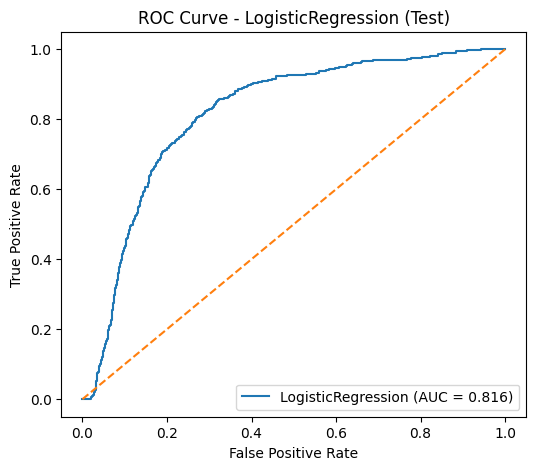

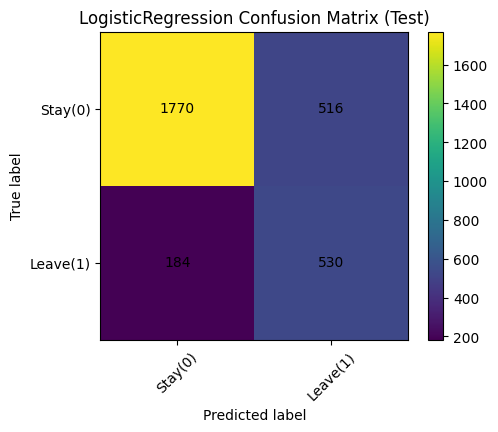

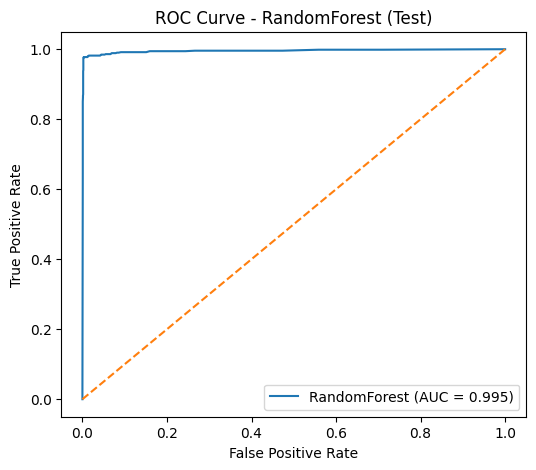

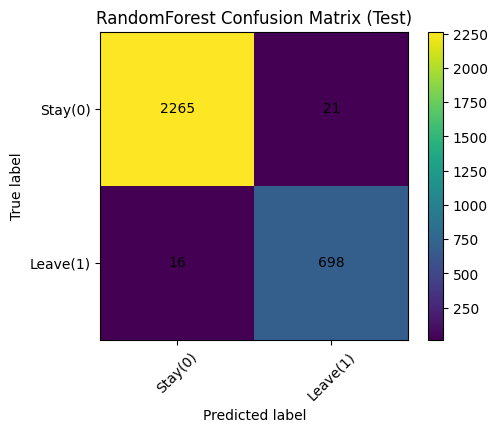

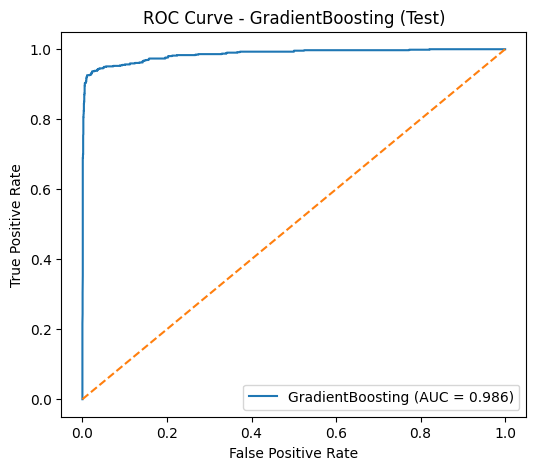

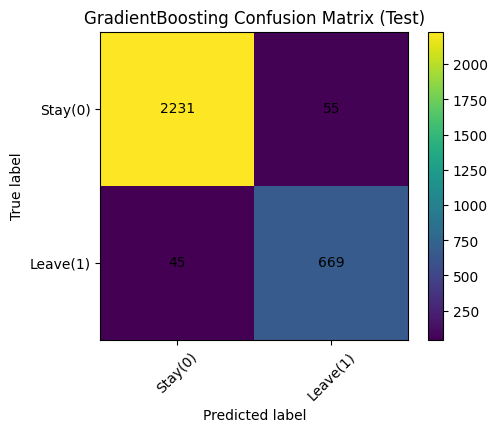

In [36]:
#BEST MODEL, PRECISION AND RECALL

from imblearn.pipeline import Pipeline

if not cv_df["cv_mean_auc"].isna().all():
    best_name = cv_df.iloc[0]["model"]
else:
    best_name = cv_df.sort_values(by=["cv_mean_f1"], ascending=False).iloc[0]["model"]

best_clf = models[best_name]
best_pipe = Pipeline([("smote", SMOTE(random_state=42)), ("clf", best_clf)])
best_pipe.fit(X_train, y_train)


test_rows = []

for name, clf in models.items():
    pipe = Pipeline([("smote", SMOTE(random_state=42)), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_val = auc(fpr, tpr)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name} (Test)")
        plt.legend(loc="lower right")
    else:
        auc_val = np.nan
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{name} Confusion Matrix (Test)")
    plt.colorbar()
    plt.xticks([0, 1], ["Stay(0)", "Leave(1)"], rotation=45)
    plt.yticks([0, 1], ["Stay(0)", "Leave(1)"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"), ha="center", va="center")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    test_rows.append({"model": name, "test_accuracy": acc, "test_precision": prec, "test_recall": rec, "test_f1": f1, "test_auc": auc_val})

test_df = pd.DataFrame(test_rows).sort_values(by=["test_auc", "test_f1"], ascending=False)

y_proba_best = best_pipe.predict_proba(X_test)[:, 1]
y_pred_best = (y_proba_best >= 0.5).astype(int)
cm_best = confusion_matrix(y_test, y_pred_best)
tn, fp, fn, tp = cm_best.ravel()
prec_best = precision_score(y_test, y_pred_best, zero_division=0)
rec_best = recall_score(y_test, y_pred_best, zero_division=0)


In [37]:
print(f"Best model: {best_name}\n")
print(f"Confusion matrix: {tn}, {fp}, {fn}, {tp}\n")
print(f"Precision: {prec_best:.3f}, Recall: {rec_best:.3f}\n")

Best model: RandomForest

Confusion matrix: 2265, 21, 16, 698

Precision: 0.971, Recall: 0.978



In [38]:
# RISK ZONES IMPL

risk_bins = [
    ("Safe Zone (Green)", 0.0, 0.20),
    ("Low Risk (Yellow)", 0.20, 0.60),
    ("Medium Risk (Orange)", 0.60, 0.90),
    ("High Risk (Red)", 0.90, 1.01),
]
def assign_zone(p):
    for name, lo, hi in risk_bins:
        if lo <= p < hi:
            return name
    return "Unknown"

pred_df = pd.DataFrame({"true_left": y_test, "predicted_prob_leave": y_proba_best})
pred_df["risk_zone"] = pred_df["predicted_prob_leave"].apply(assign_zone)
pred_df.head()



,true_left,predicted_prob_leave,risk_zone
0,0,0.00,Safe Zone (Green)
1,0,0.64,Medium Risk (Orange)
2,0,0.02,Safe Zone (Green)
3,0,0.00,Safe Zone (Green)
4,0,0.00,Safe Zone (Green)
